# Firdaus Adi Nugroho - Astra Data Scientist Bootcamp

# 1. Business Understanding
German Credit adalah sebuah perusahaan yang bergerak pada bidang keuangan berupa jasa pemberian kredit kepada pelanggannya. Oleh karena itu, kami diminta untuk mengkluster pelanggan agar menunjang German Credit untuk mengetahui kluster apa saja yang ada dan tindakan yang akan dilakukan marketing untuk mengambil aksi dalam peningkatan jumlah pelanggan maupun profit.

# 2. Data Understanding
Dataset German Credit ini memiliki 1000 baris dan 20 atribut. Pada dataset ini, setiap data merepresentasikan customer yang akan dikluster berdasarkan bisa mengambil credit bank atau tidak. Setiap orang diklasterisasi berdasarkan bagus, medium, dan bad credit risk berdasarkan atribut yang ada


# 3. Data Preparation
Berikut adalah persiapan-persiapan data yang harus dilakukan sebelum dilakukannya analisis

In [313]:
#Mengimport Library Package

%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

In [314]:
# Load the dataset

data = pd.read_csv('german_credit_data.csv')

## Data Preparation

In [315]:
# Melihat dimensi dari dataset

data.shape

(1000, 10)

In [316]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [317]:
#Melihat informasi dari dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Unnamed: 0          1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


Melakukan cek missing value terhadap dataset, sehingga jika ada terdapat aksi-aksi yang dapat dilakukan. Apakah merubah menjadi rataan, median, modus atau bahkan kolom tersebut dihapus jika missing value diangka diatas 60%

In [390]:
sum_null = data.isnull().sum()
sum_null = pd.DataFrame(sum_null,columns=['null'])
j=1
sum_tot = len(data)
sum_null['percent']=sum_null['null']/sum_tot
round(sum_null,3).sort_values('percent', ascending=False)

,null,percent
Checking account,394,0.394
Saving accounts,183,0.183
Unnamed: 0,0,0.000
Age,0,0.000
Sex,0,0.000
Job,0,0.000
Housing,0,0.000
Credit amount,0,0.000
Duration,0,0.000
Purpose,0,0.000


Melakukan split antara data kategorikal dan numerik

In [392]:
numeric = data.columns[[1,7,8,10]]
data_numeric = data[numeric]
categorical = data.drop(columns=numeric,axis=1)
data_categorical = data.columns
sum_null.loc[data_categorical,:].sort_values(by='percent',ascending=False)

,null,percent
Checking account,394,0.394
Saving accounts,183,0.183
Unnamed: 0,0,0.000
Age,0,0.000
Sex,0,0.000
Job,0,0.000
Housing,0,0.000
Credit amount,0,0.000
Duration,0,0.000
Purpose,0,0.000


In [69]:
categorical=categorical.drop(categorical.columns[0], axis=1)

In [70]:
categorical.describe()

,Job
count,1000.000000
mean,1.904000
std,0.653614
min,0.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,3.000000


In [71]:
categorical['Job']=pd.Categorical(categorical['Job'])

In [72]:
categorical.describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
count,1000,1000,1000,817,606,1000
unique,2,4,3,4,3,8
top,male,2,own,little,little,car
freq,690,630,713,603,274,337


In [73]:
data[data_categorical]['Job']=pd.Categorical(data[data_categorical]['Job'])

In [319]:
data[numeric].head()

,Age,Credit amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24


Melakukan aksi terhadap data yang memiliki missing value, pada kasus ini kolom Checking account dan Saving memiliki missing value tetapi tidak lebih dari 60%. Karena kolom nya berjenis kategorial, sehingga kita melakukan aksi menjadikan data null menjadi modus

In [75]:
data['Checking account'].fillna(categorical['Checking account'].mode()[0], inplace=True)
data['Saving accounts'].fillna(categorical['Checking account'].mode()[0], inplace=True)

In [76]:
#Mengecek kembali missing value

sum_null = data.isnull().sum()
sum_null = pd.DataFrame(sum_null,columns=['null'])
j=1
sum_tot = len(data)
sum_null['percent']=sum_null['null']/sum_tot
round(sum_null,3).sort_values('percent', ascending=False)

,null,percent
Unnamed: 0,0,0.0
Age,0,0.0
Sex,0,0.0
Job,0,0.0
Housing,0,0.0
Saving accounts,0,0.0
Checking account,0,0.0
Credit amount,0,0.0
Duration,0,0.0
Purpose,0,0.0


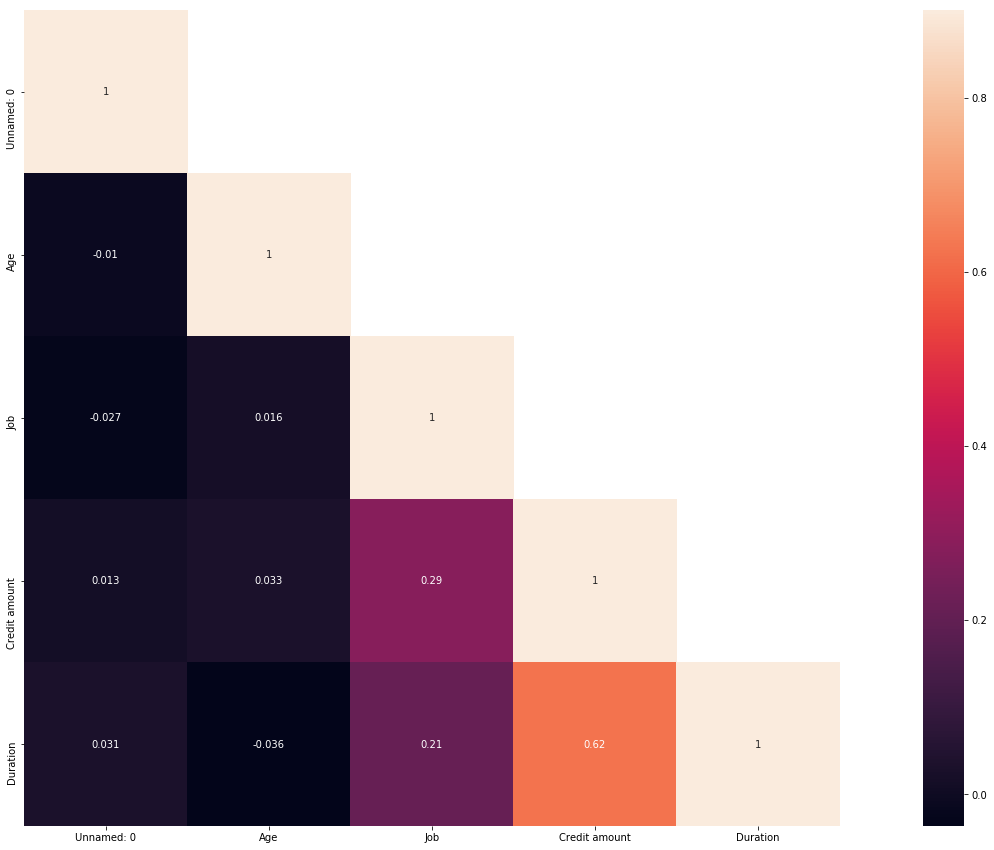

In [320]:
#create correlation with hitmap

#from this correlation, we know the value percentages of the correlation(1 or -1). The bigger value, so the correlation has big value too.
#weather has big correlation with the lattitude (-0,78). 

#create correlation
corr = data.corr(method = 'pearson')

#convert correlation to numpy array
mask = np.array(corr)

#to mask the repetitive value for each pair
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize = (15,12))
fig.set_size_inches(30,15)
sns.heatmap(corr, mask = mask, vmax = 0.9, square = True, annot = True)

Pada korelasi Heatmap ini kita dapat melihat korelasi terhadap satu fitur ke fitur yg lain. Pada Heatmap ini, kita bisa melakukan pengolahan data dan klustering terhadap Credit amount dan Duration yang memiliki nilai paling tinggi ialah 0,62. Diikuti dengan Job terhadap Credit amount, dan Job terhadap Duration

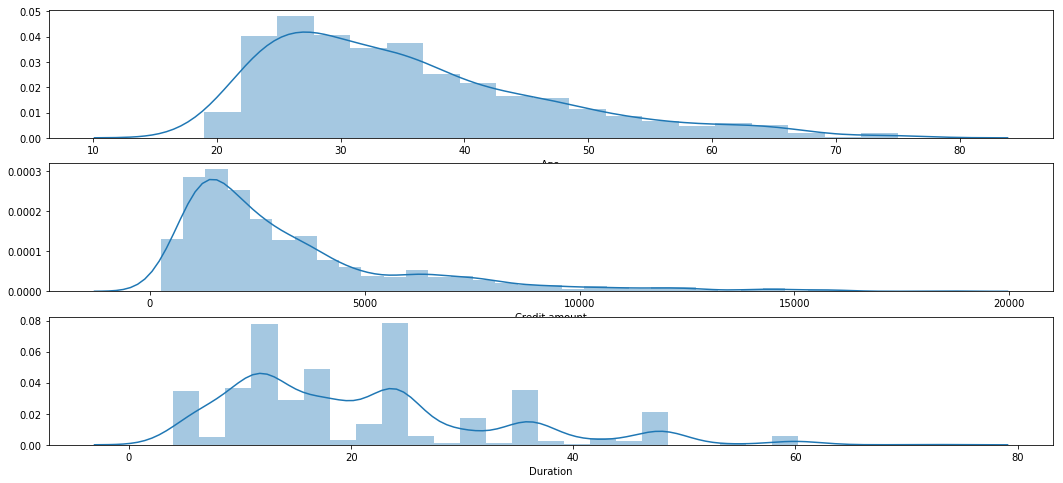

In [597]:
#Plot distribusi terhadap Age, Credit amount, Age dan Duration
f=plt.figure(figsize=(18,8))
j=1
for i in numeric[[0,1,2]]:
    f.add_subplot(3,1,j)
    sns.distplot(data[i])
    j+=1
plt.show()

Grafik diatas adalah grafik yang mendeskripsikan analisis bivariat dengan fitur Age, Credit Amount, Duration

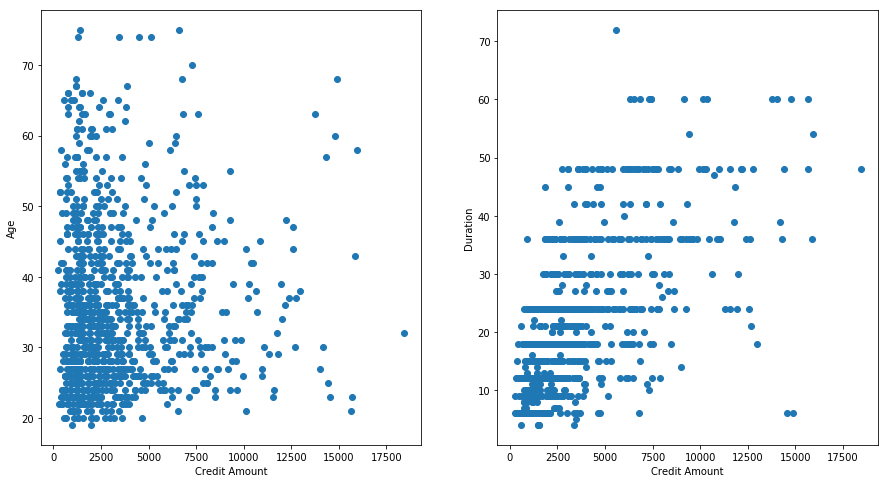

In [595]:
f = plt.figure(figsize=(15,8))

f.add_subplot(1,2,1)
plt.scatter(data['Credit amount'], data['Age'])
plt.xlabel('Credit Amount')
plt.ylabel('Age')

f.add_subplot(1,2,2)
plt.scatter(data['Credit amount'], data['Duration'])
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.show()

Pada Scatter plot diatas menggambarkan hubungan antara Credit Amount terhadap Age dan Duration. Sehingga kita bisa melihat persebaran data antara hubungan 2 variabel tersebut

<function matplotlib.pyplot.show>

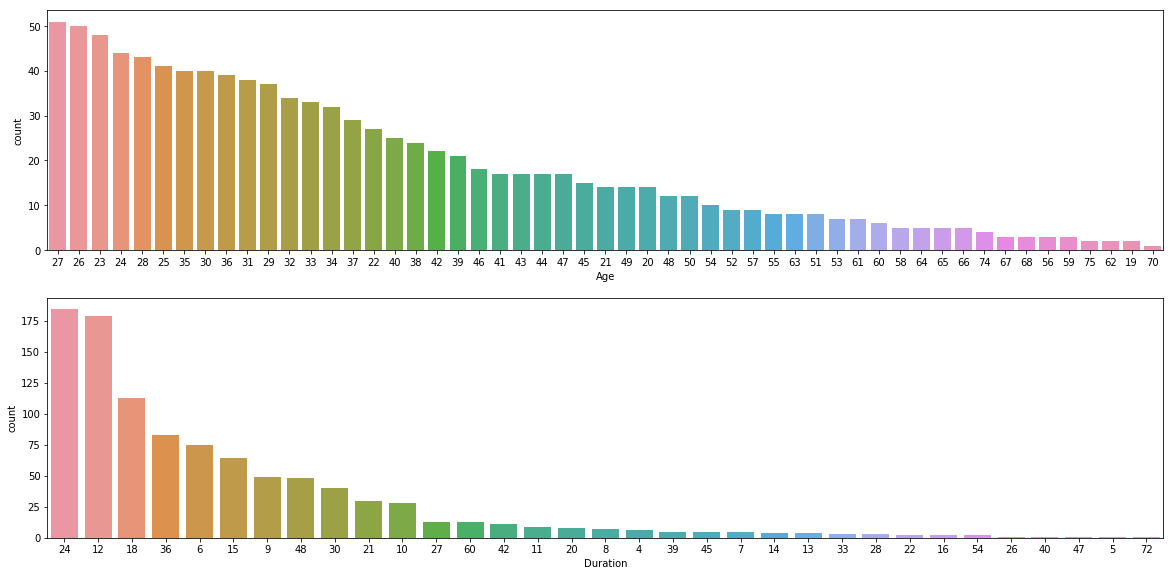

In [598]:
f=plt.figure(figsize=(20,15))
j=1
for i in numeric[[0,2]]:
    f.add_subplot(3,1,j)
    sns.countplot(data[i],order=data[i].value_counts().index)
    j+=1
plt.show

In [29]:
data[numeric].describe()

,Age,Credit amount,Duration
count,999.000000,999.000000,999.000000
mean,35.559560,3268.575576,20.875876
std,11.373078,2822.875249,12.034295
min,19.000000,250.000000,4.000000
25%,27.000000,1365.000000,12.000000
50%,33.000000,2319.000000,18.000000
75%,42.000000,3969.000000,24.000000
max,75.000000,18424.000000,72.000000


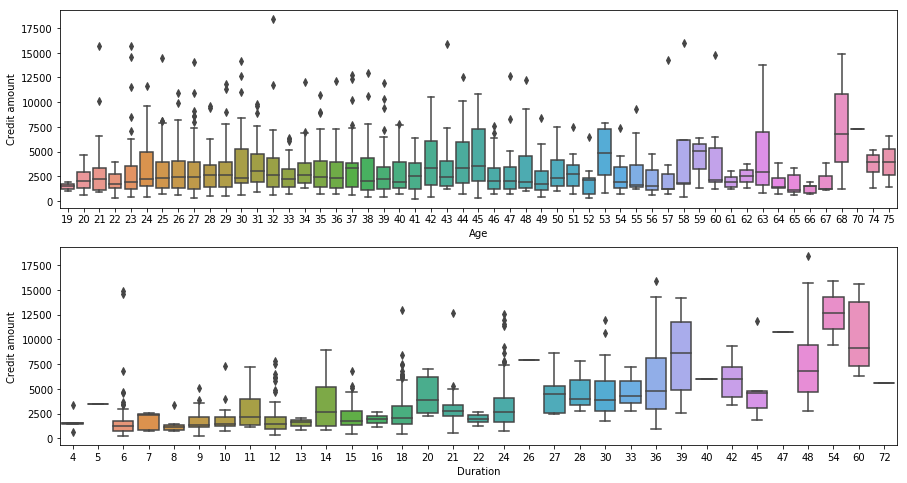

In [30]:
f = plt.figure(figsize=(15,8))
f.add_subplot(2,1,1)
sns.boxplot(y=data['Credit amount'], x=data['Age'])

f.add_subplot(2,1,2)
sns.boxplot(y=data['Credit amount'], x=data['Duration'])
plt.show()

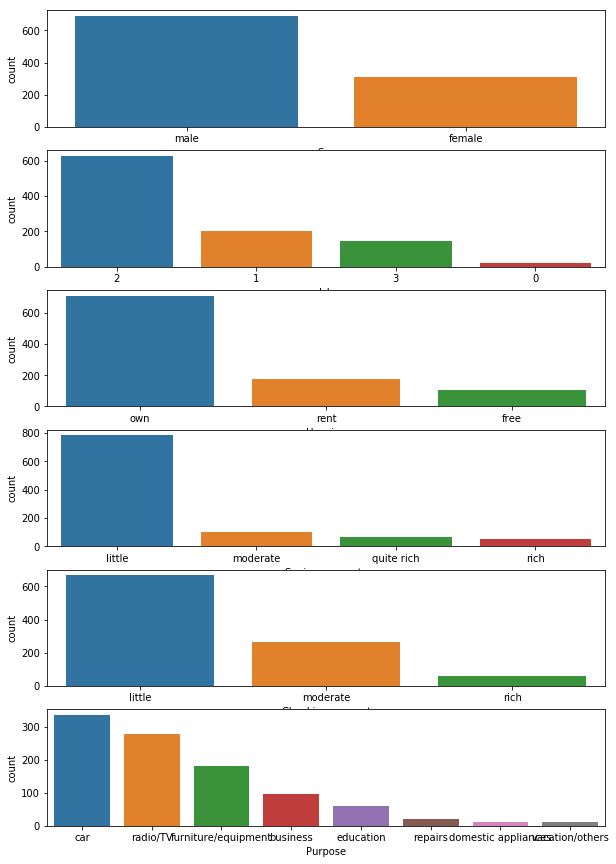

In [31]:
f = plt.figure(figsize=(10,15))
j=1
for i in categorical[0:5]:
    f.add_subplot(6,1,j)
    sns.countplot(data[i], order=data[i].value_counts().index)
    j+=1
plt.show()

In [32]:
categorical.describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
count,999,999,999,816,605,999
unique,2,4,3,4,3,8
top,male,2,own,little,little,car
freq,690,629,712,602,274,337


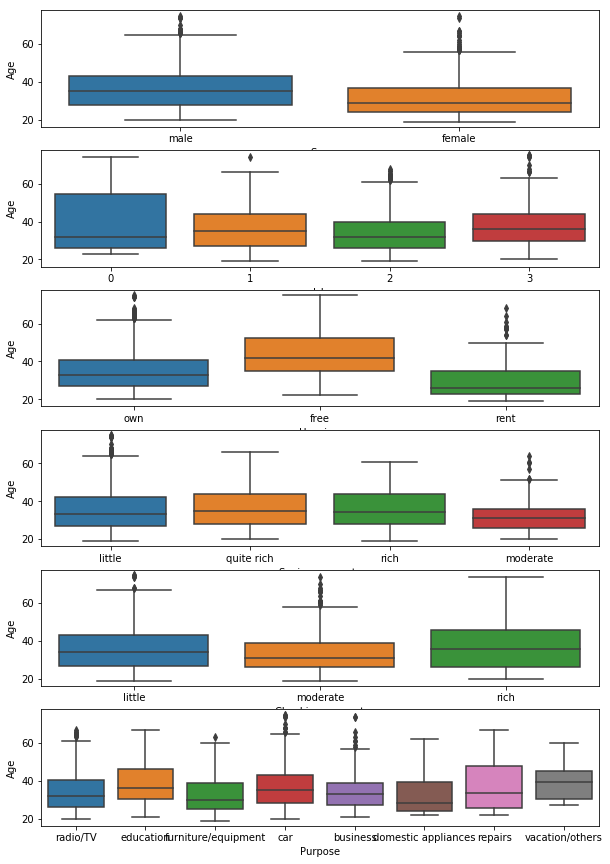

In [33]:
f = plt.figure(figsize=(10,15))
j=1
for i in categorical[0:5]:
    f.add_subplot(6,1,j)
    sns.boxplot(data[i], data['Age'])
    j+=1
plt.show()

In [34]:
categorical.describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
count,999,999,999,816,605,999
unique,2,4,3,4,3,8
top,male,2,own,little,little,car
freq,690,629,712,602,274,337


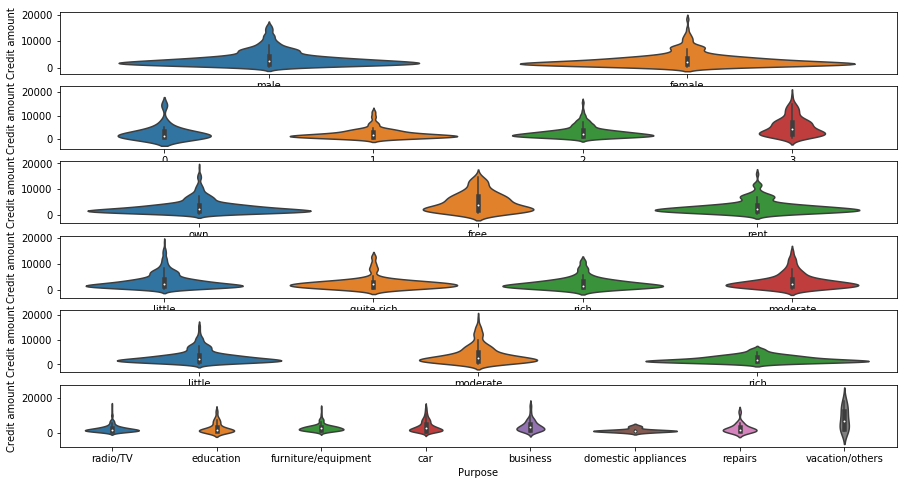

In [35]:
f= plt.figure(figsize=(15,8))
j=1
for i in categorical[0:5]:
    f.add_subplot(6,1,j)
    sns.violinplot(data[i],data['Credit amount'])
    j+=1
plt.show()

In [381]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


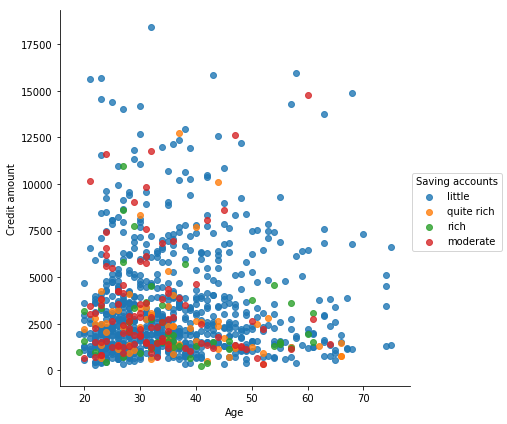

In [112]:
sns.lmplot(x='Age', y='Credit amount',data=data, fit_reg= False, hue = 'Saving accounts', size = 6,aspect = 1)

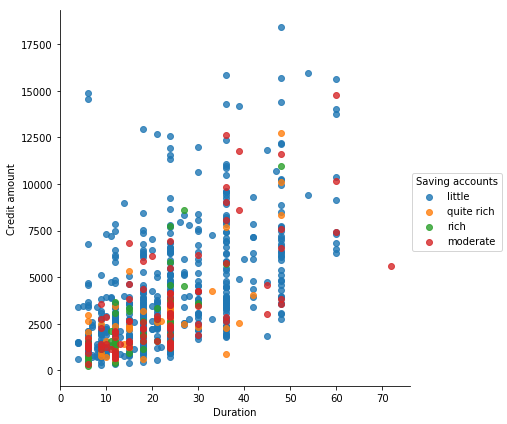

In [114]:
sns.lmplot(x='Duration', y='Credit amount',data=data, fit_reg= False, hue = 'Saving accounts', size = 6,aspect = 1)

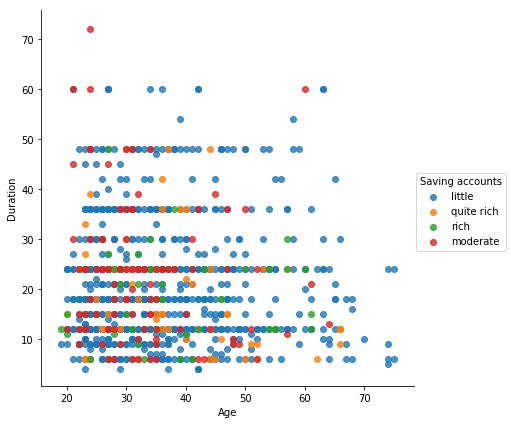

In [129]:
sns.lmplot(x='Age', y='Duration',data=data, fit_reg= False, hue = 'Saving accounts', size = 6,aspect = 1)

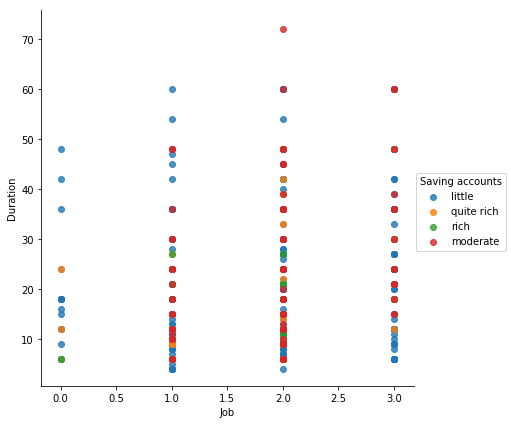

In [131]:
sns.lmplot(x='Job', y='Duration',data=data, fit_reg= False, hue = 'Saving accounts', size = 6,aspect = 1)

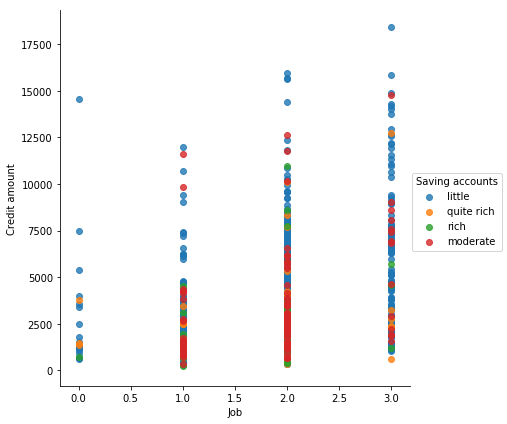

In [132]:
sns.lmplot(x='Job', y='Credit amount',data=data, fit_reg= False, hue = 'Saving accounts', size = 6,aspect = 1)

In [440]:
#def scatters(scat, h=None, pal=None):
    #fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    #sns.lmplot(x="Credit amount",y="Duration", data = data, fit_reg = False, hue = h, size = 6, aspect = 1)
    #sns.lmplot(x="Age",y="Credit amount", data = data, fit_reg = False, hue = h, size = 6, aspect = 1)
    #sns.lmplot(x="Age",y="Duration", data = data, fit_reg = False, hue = h, size = 6, aspect = 1)
    #plt.tight_layout()

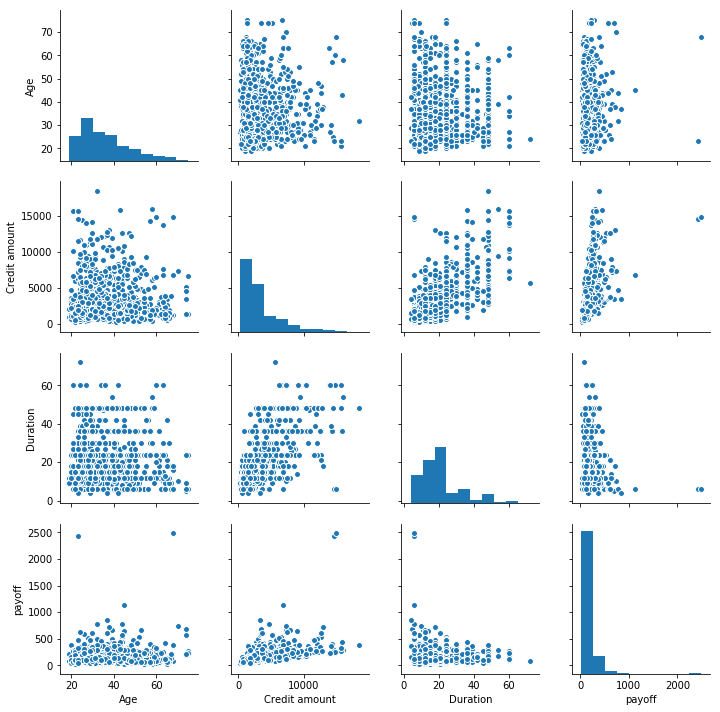

In [600]:
sns.pairplot(data_numeric)

# 4. Modelling
Fase selanjutnya adalah fase permodelan. Berikut adalah hal-hal yang perlu dilakukan untuk fase permodelan :
Fase ini adalah fase dimana kita memilih modeling yang paling tepat dalam studi kasus ini khususnya yaitu studi kasus German Credit. Pada kasus ini, model yang digunakan ialah Unsupervised learning dengan model jenis Clustering yaitu menggunakan K-Means, Hierarical Clustering dan DBSCAN

## K-Means #1 
Metode K-Means Clustering berusaha mengelompokkan data yang ada ke dalam beberapa kelompok, dimana data dalam satu kelompok mempunyai karakteristik yang sama satu sama lainnya dan mempunyai karakteristik yang berbeda dengan data yang ada di dalam kelompok yang lain.

In [455]:
X= np.asarray(data_numeric)

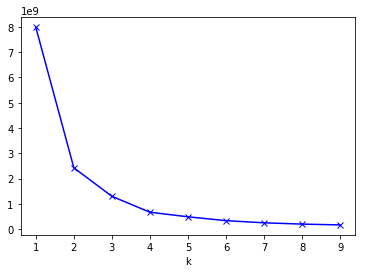

In [601]:
#Menentukan nilai K yang akan dipilih

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.show()

Dalam modeling K-Means, Hal yang harus diketahui terlebih dahulu ialah nilai K yang harus ditentukan terlebih dahulu untuk melakukan clustering untuk membagi berapa Cluster yang akan ditentukan

In [604]:
# Melakukan aktivasi algoritma K-Means dan memilih K
kmeans = KMeans(n_clusters=3)
y_kmeans = kmeans.fit_predict(X)

In [605]:
# Menampilkan nilai centroid yang dibangkitkan oleh algoritma kmeans 
print(kmeans.cluster_centers_)

[[   36.25        5640.57727273    29.92272727   229.18605462]
 [   35.30235784  1871.74618585    16.65603329   131.34547151]
 [   35.89830508 11539.01694915    39.16949153   382.47463515]]


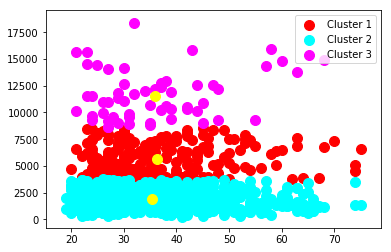

In [606]:
#plot data dengan menggunakan kMeans dan nilai K yang sudah ditentukan

plt.scatter(X[y_kmeans==0,0], X[y_kmeans==0,1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans==1,0], X[y_kmeans==1,1], s=100, c='cyan', label='Cluster 2')
plt.scatter(X[y_kmeans==2,0], X[y_kmeans==2,1], s=100, c='magenta', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=100, c='yellow')
plt.legend()

#### Klustering dua dimensi diatas memberikan informasi bahwa:<br>
Cluster 1(Merah): Pelanggan yang tergolong jumlah kredit menengah berdasarkan umur<br>
Cluster 2(Cyan): Pelanggan yang tergolong jumlah kredit sedikit berdasarkan umur<br>
Cluster 3(Magenta): Pelanggan yang tergolong jumlah kredit besar berdasarkan umur<br>

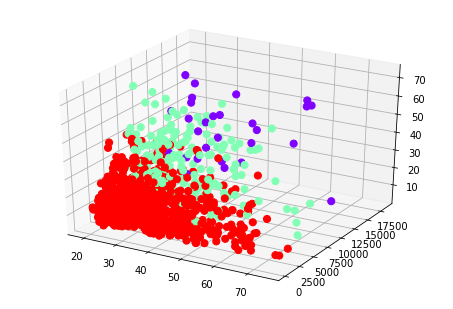

In [607]:
from mpl_toolkits.mplot3d import axes3d,Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0],X[:,1], X[:,2], c=labels,cmap='rainbow', alpha=1,s=50)

#### Klustering Tiga Dimensi diatas memberikan informasi bahwa:

Cluster Merah: Menggambarkan bahwa Cluster ini memiliki tingkat Kredit rendah, dengan durasi yang rendah <br>
Cluster Hijau Muda: Menggambarkan bahwa Cluster ini memiliki tingkat kredit yang menengah dengan durasi yang menengah <br>
Cluster Ungu: Menggambarkan bahwa Cluster ini memiliki jumlalh tingkat Kredit yang tinggi, dengan durasi yang tinggi juga <br>

In [627]:
#test score K-Means

from sklearn.metrics import silhouette_score

labels = kmeans.labels_
silhouette_score(X, labels)

0.37817627719649183

## K-Means #2 
K-Means kedua ini mengklusterirasi tambahan fitur yaitu fitur payoff(Jumlah kredit dengan durasi) dengan umur

In [608]:
#membuat fitur baru bernama payoff 
data['payoff'] =( data['Credit amount']/data['Duration'])
data['payoff'].describe

<bound method NDFrame.describe of 0      194.833333
1      123.979167
2      174.666667
3      187.666667
4      202.916667
5      251.527778
6      118.125000
7      193.000000
8      254.916667
9      174.466667
10     107.916667
11      89.750000
12     130.583333
13      49.958333
14      93.533333
15      53.416667
16     101.000000
17     269.066667
18     524.125000
19     142.916667
20     237.111111
21     441.166667
22     224.100000
23     150.333333
24     206.900000
25     229.000000
26      71.000000
27      34.083333
28     345.000000
29     113.933333
          ...    
970    100.933333
971    308.041667
972     49.708333
973    121.616667
974     94.366667
975     52.416667
976    125.500000
977    134.833333
978    105.750000
979     84.266667
980    279.533333
981    100.916667
982    139.190476
983    228.583333
984     84.500000
985     95.533333
986    149.738095
987    108.384615
988    274.125000
989     72.625000
990    297.083333
991    104.600000
992    107.5

In [609]:
numeric1 = data.columns[[1,10]]
data_numeric1 = data[numeric1]

X1 = np.asarray(data_numeric1) 

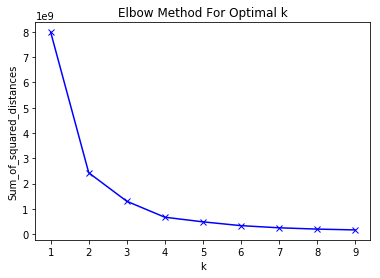

In [614]:
#Menentukan nilai K yang akan dipilih

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [618]:
# Melakukan aktivasi algoritma K-Means
kmeans1 = KMeans(n_clusters=3)
y_kmeans1 = kmeans.fit_predict(X1)

In [619]:
# Menampilkan nilai centroid yang dibangkitkan oleh algoritma kmeans 
print(kmeans.cluster_centers_)

[[  35.16136919  121.83629631]
 [  37.18333333  350.6468337 ]
 [  45.5        2454.25      ]]


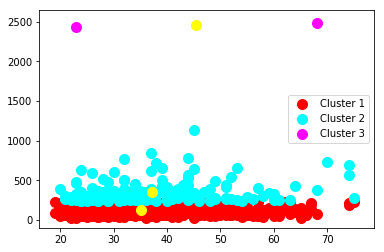

In [621]:
#plot data dengan menggunakan kMeans dan nilai K yang sudah ditentukan

plt.scatter(X1[y_kmeans1==0,0], X1[y_kmeans1==0,1], s=100, c='red', label='Cluster 1')
plt.scatter(X1[y_kmeans1==1,0], X1[y_kmeans1==1,1], s=100, c='cyan', label='Cluster 2')
plt.scatter(X1[y_kmeans1==2,0], X1[y_kmeans1==2,1], s=100, c='magenta', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=100, c='yellow')
plt.legend()

#### Klustering dua dimensi diatas memberikan informasi bahwa:<br>
Cluster 1(Merah): Pelanggan yang tergolong jumlah pembayaran tiap bulan rendah berdasarkan umur<br>
Cluster 2(Cyan): Pelanggan yang tergolong jumlah pembayaran tiap bulan menengah sedikit berdasarkan umur<br>
Cluster 3(Magenta): Pelanggan yang tergolong jumlah pembayaran tiap bulan besar berdasarkan umur<br>

In [626]:
#test score K-Means

from sklearn.metrics import silhouette_score

labels = kmeans.labels_
silhouette_score(X1, labels)

0.6532468802023834

# Hierarical Clustering
Pada hierarchical clusteringdata dikelompokkan melalui suatu bagan yang berupa hirarki, dimana terdapat penggabungan dua grup yang terdekat disetiap iterasinya ataupun pembagian dari seluruh set data kedalam cluster.
Terdapat beberapa metode dalam Hierarical Clustering yaitu: <br>
1. Metode Ward
2. Metode Average
3. Metode Complete

Langkah Algoritma Agglomerative Hierarchical Clustering :

1. Hitung Matrik Jarak antar data.<br>
2. Gabungkan dua kelompok terdekat berdasarkan parameter kedekatan yang ditentukan.<br>
3. Perbarui Matrik Jarak antar data untuk merepresentasikan kedekatan diantara kelompok baru dan kelompok yang masih tersisa.<br>
4. Ulangi langkah 2 dan 3 higga hanya satu kelompok yang tersisa.<br>

In [551]:
# Melakukan transformasi nilai agar distribusinya normal yaitu dengan transformasi logaritmik
cluster_log = np.log(X)

## Hierarical Clustering Ward Method

Text(0,0.5,'Jarak Euclidean')

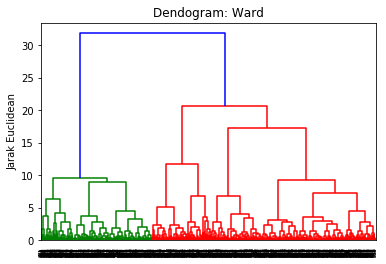

In [565]:
# Membentuk dendogram dengan metode ward 
dendrogram_ward = sch.dendrogram(sch.linkage(cluster_log, method='ward'))
plt.title('Dendogram: Ward')
plt.ylabel('Jarak Euclidean')

In [552]:
# Melakukan fitting hierarchical clustering 
model_ward = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hc = model_ward.fit_predict(cluster_log)

## Hierarical Clustering Average Method

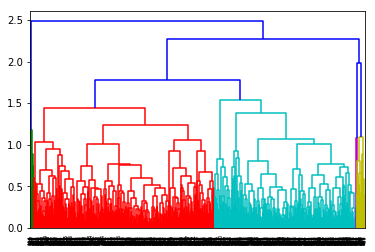

In [453]:
# Membentuk dendogram dengan metode Average

dendrogram_single = sch.dendrogram(sch.linkage(cluster_log, method='average'))

In [554]:
# Melakukan fitting hierarchical clustering 
model_average = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='average')
hc1 = model_average.fit_predict(cluster_log)

## Hierarical Clustering Complete Method

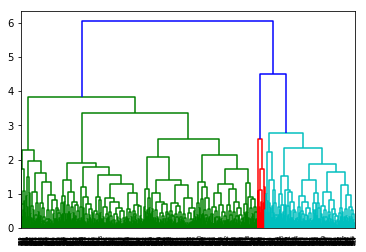

In [535]:
# Membentuk dendogram dengan metode Complete

dendrogram_complete = sch.dendrogram(sch.linkage(cluster_log, method='complete'))

In [555]:
# Melakukan fitting hierarchical clustering 
model_complete = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hc2 = model_complete.fit_predict(cluster_log)

### Mengecek skor dari setiap metode pada Metode Hierarical Clustering

In [624]:
model1_ward = silhouette_score(cluster_log, hc, metric = 'euclidean')
model1_average = silhouette_score(cluster_log, hc1, metric = 'euclidean')
model1_complete = silhouette_score(cluster_log, hc2, metric = 'euclidean')

print('Hasil test score dari Metode Ward: ', model1_ward)
print('Hasil test score dari Metode Average: ', model1_average)
print('Hasil test score dari Metode Complete: ', model1_complete)

Hasil test score dari Metode Ward:  0.2636788861972793
Hasil test score dari Metode Average:  0.19540864152871867
Hasil test score dari Metode Complete:  0.3244996197116262


# DBSCAN

In [572]:
#import library DBSCAN

from sklearn.cluster import DBSCAN
from sklearn import datasets

In [560]:
print(dir(data))

['Age', 'Duration', 'Housing', 'Job', 'Purpose', 'Sex', 'T', '_AXIS_ALIASES', '_AXIS_IALIASES', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '_AXIS_SLICEMAP', '__abs__', '__add__', '__and__', '__array__', '__array_wrap__', '__bool__', '__bytes__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__finalize__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lt__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '_

In [569]:
# Melakukan aktivasi algoritma DBSCAN
dbscan = DBSCAN(eps = 0.5)
dbscan.fit(cluster_log)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [570]:
# Menampilkan label dibangkitkan oleh algoritma dbscan 
print(dbscan.labels_)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Text(0,0.5,'Age')

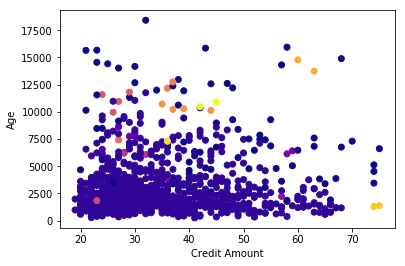

In [631]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.5, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Credit Amount")
plt.ylabel("Age")

Hasil DBSCAN dengan nilai epsilon 2 dan minimal sample 2. Dilihat dari grafik diatas bahwa tingkat noise dengan epsilon dan minimal sample yang sudah ditentukan masih ada

In [574]:
#test score akurasi dari DBSCAN

dbscan = DBSCAN(eps=0.5)
model_dbscan = dbscan.fit_predict(cluster_log)
print(silhouette_score(cluster_log, labels))

0.2859123868799354


# 5. Evaluation


#### Evaluasi
Pada tahapan Evaluasi ini, menentukan bahwa model mana yang terbaik dari ketiga model yaitu K-Means, Hierarical Clustering, dan DBSCAN. <br>
Dengan berbagai pertimbangan yaitu hasil grafik clustering, dan hasil uji tes silhouette score<br>
<br>
K-Means merupakan metode terbaik yang dapat digunakan untuk Klastering, Selain hasil mapping yang cukup jelas, dan tingkat akurasi dari uji tes silhouette yang cukup baik
<br><br>

### Keuntungan dari Klustering
Dengan Klustering yang sudah saya buat, adapun beberapa keuntungan untuk perusahaan German Credit yaitu:<br>
1. Kita dapat mengkluster pelanggan mana yang memiliki kredit yang tinggi dengan durasi tinggi dan usia tertentu sehingga kita dapat kategorikan sebagai Pelanggan yang Bad. Sehingga kita dapat memberikan aksi berupa penawaran kredit jangka panjang dengan produk yang produktivitasnya tinggi. Contoh: Kredit Rumah ataupun Motor<br>
2. Kita dapat mengkulster pelanggan mana yang memiliki kredit menengah dengan durasi menengah dengan usia tertentu sehingga kita dapat kategorikan sebagai Pelanggan yang Medium. Sehingga kita dapat memberikan aksi berupa penawaran kredit jangka menengah dengan produktivitas yang tidak terlalu tinggi. Contoh: Kredit Properti, Kredit Gadget.<br>
2. Kita dapat mengkulster pelanggan mana yang memiliki kredit Rendah dengan durasi rendah dengan usia tertentu sehingga kita dapat kategorikan sebagai Pelanggan yang Bagus. Sehingga kita dapat memberikan aksi berupa penawaran kredit jangka pendek, menengah maupun jangka panjang. Contoh: Mobil Sport, ataupun peralatan hobi